<h1 style="text-align:center">Spring Pendulum Example</h1>
<h3 style="text-align:center">MCHE 513: Intermediate Dynamics</h3> 
<p style="text-align:center">Dr. Joshua Vaughan <br>
<a href="mailto:joshua.vaughan@louisiana.edu">joshua.vaughan@louisiana.edu</a><br>
<a href="http://www.ucs.louisiana.edu/~jev9637/">http://www.ucs.louisiana.edu/~jev9637/</a></p>

In this example, we'll determine the equations of motion for the spring pendulum system shown in Figure 1. The system consists of a point mass, $m$, connected to an ideal pin by a spring of stiffness $k$. The rotation of the pendulum is represented by $\theta$ and the length of the spring by $R$. The equilibrium length of the spring is $L_0$.

<p style="text-align:center">
	<img src="http://shared.crawlab.org/Spring_Pendulum.png" alt="Spring Pendulum" width=25%><br>
    <strong>Figure 1: Spring Pendulum</strong>
</p>

In [1]:
# Import the SymPy Module
import sympy

# Import the necessary sub-modules and methods for dynamics
from sympy.physics.mechanics import dynamicsymbols
from sympy.physics.mechanics import LagrangesMethod, Lagrangian
from sympy.physics.mechanics import Particle, Point, ReferenceFrame

# initiate better printing of SymPy results
sympy.init_printing()

In [2]:
# Set up the display for retina screens
#
# Default setting can also be changes in in ipython_kernel_config.py
#    c.InlineBackend.figure_formats = set(['retina'])
# See: https://twitter.com/miishke/status/670045268562329600

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [3]:
# Define the genearlized coordinate
R, theta = dynamicsymbols('R theta')

# Also define the first derivative
R_dot, theta_dot = dynamicsymbols('R theta', 1)

# Define the symbols for the other paramters
m, g, k, l0, t = sympy.symbols('m g k L_0 t')

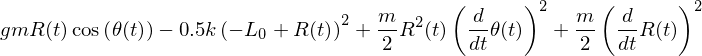

In [4]:
# Define the Newtonian reference frame
N = ReferenceFrame('N')

# Define a body-fixed frame along the pendulum, with y aligned from m to the pin
A = N.orientnew('A', 'Axis', [theta, N.z])

# Define the points and set its velocity
P = Point('P')
P.set_vel(N, R * theta_dot * A.x - R_dot * A.y)

mp = Particle('mp', P, m)

mp.set_potential_energy(-m * g * R * sympy.cos(theta) + 1/2 * k * (R - l0)**2)

# Set up the force list - each item follows the form:
#    (the location where the force is applied, its magnitude and direction)
# Here, there are no non-conservataive external forces
forces = []

# Form the Lagrangian
L =  Lagrangian(N, mp)

# Print the Lagrangian as a check
L

In [5]:
# This creates a LagrangesMethod class instance that will 
# allow us to form the equations of motion, etc
LM = LagrangesMethod(L, [R, theta], forcelist = forces, frame = N)

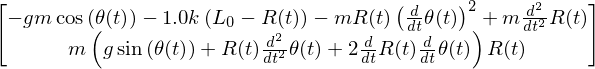

In [6]:
# Form the equations fo motion
EqMotion = LM.form_lagranges_equations()

# Print the simplified version of the equations of motion
sympy.simplify(EqMotion)

The <tt>LagrangesMethod</tt> class gives us lots of information about the system. For example, we can output the mass/inertia matrix and the forcing terms. Note that the forcing terms include what might be conservative forces and would therefore normally appear in a stiffness matrix.

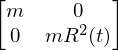

In [7]:
# Output the inertia/mass matrix of the system
LM.mass_matrix

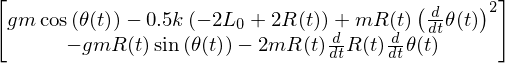

In [8]:
# Output the forcing terms of the system
LM.forcing

We can also use builtin functions to write the sytsem as a set of first order ODEs, suitable for simluation.

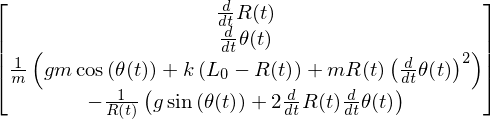

In [9]:
# Make the call to set up in state-space-ish form q_dot = f(q, t)
lrhs = LM.rhs()

# Simplify the results
lrhs.simplify()

# Output the result
lrhs

We can also linearize these equations with builtin SymPy methods. Let's do so about the $\theta = 0$, $\dot{\theta} = 0$ operating point. The resulting equations returned are a system of first order ODEs in state-space form:

$$ \dot{x} = Ax + Bu $$

See the [SymPy Documentation](http://docs.sympy.org/0.7.6/modules/physics/mechanics/linearize.html#linearizing-lagrange-s-equations) for much more information.

In [10]:
# Define the point to linearize around
operating_point = {R: l0, R_dot: 0.0, theta: 0.0, theta_dot: 0.0}

# Make the call to the linearizer
A, B, inp_vec = LM.linearize([R, theta], [R_dot, theta_dot],
                             op_point = operating_point, 
                             A_and_B = True)

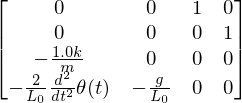

In [11]:
A

In [12]:
B

## Simulation
We can pass these equations of motion to numerical solver for simluation. To do so, we need to import [NumPy](http://numpy.org) and the [SciPy](http://www.scipy.org) ode solver, ```ode```. We'll also import [matplotlib](http://www.scipy.org) to enable plotting of the results.

For a system as simple as this one, we could easily set up the necessary components for the numerical simulation manually. However, here we will automate as much as possible. Following a similar procedure on more complicated systems would be necessary.

In [13]:
# import NumPy with namespace np
import numpy as np

# import the scipy ODE solver
from scipy.integrate import ode

# import the plotting functions from matplotlib
import matplotlib.pyplot as plt

# set up the notebook to display the plots inline
%matplotlib inline

In [14]:
# Define the states and state vector
w1, w2, w3, w4 = sympy.symbols('w1 w2 w3 w4', cls=sympy.Function)
w = [w1(t), w2(t), w3(t), w4(t)]

# Set up the state definitions and parameter substitution
sub_params = {R : w1(t),
              theta: w2(t),
              R_dot : w3(t),
              theta_dot: w4(t), 
              m : 1.0,
              g : 9.81,
              k : 10.0,
              l0 : 2.0}

# set this parameter to enable array output from sympy.lambdify
mat2array = [{'ImmutableMatrix': np.array}, 'numpy']

# Create a function from the equations of motion
# Here, we substitude the states and parameters as appropriate prior to the lamdification
eq_of_motion = sympy.lambdify((t, w), 
                              lrhs.subs(sub_params), 
                              modules = mat2array)

In [15]:
# Set up the initial conditions for the solver
R_init = 2.5                   # Initial spring length
R_dot_init = 0.0               # Initial radial velocity
theta_init = 10.0 * np.pi/180    # Initial angle
theta_dot_init = 0.0           # Initial angular velocity

# Pack the initial conditions into an array
x0 = [R_init, theta_init,  R_dot_init, theta_dot_init]

# Create the time samples for the output of the ODE solver
sim_time = np.linspace(0.0, 10.0, 1001) # 0-10s with 1001 points in between

In [16]:
# Set up the initial point for the ode solver
r = ode(eq_of_motion).set_initial_value(x0, sim_time[0])
 
# define the sample time
dt = sim_time[1] - sim_time[0]   

# pre-populate the response array with zeros
response = np.zeros((len(sim_time), len(x0)))

# Set the initial index to 0
index = 0

# Now, numerically integrate the ODE while:
#   1. the last step was successful
#   2. the current time is less than the desired simluation end time
while r.successful() and r.t < sim_time[-1]:
    response[index, :] = r.y
    r.integrate(r.t + dt)
    index += 1

Now, let's plot the results. The first column of the ```response``` vector is the radial position of the endpoint, $R$, and the second is angle of the pendulum, $\theta$. We first plot $R$, then $\theta$ below, after setting up plotting parameters to make the plot more readable.

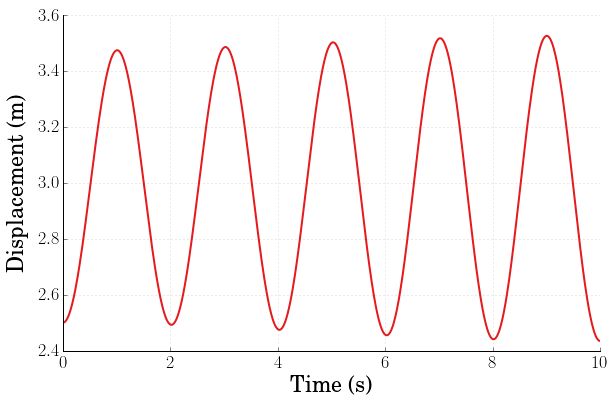

In [17]:
# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(), family='serif', fontsize=18)
plt.setp(ax.get_xmajorticklabels(), family='serif', fontsize=18)

# Remove top and right axes border
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Only show axes ticks on the bottom and left axes
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':', color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Displacement (m)', family='serif', fontsize=22, weight='bold', labelpad=10)

# Plot the data
plt.plot(sim_time, response[:, 0], linewidth=2, linestyle='-', label = 'R')

# uncomment below and set limits if needed
# plt.xlim(0, 5)
# plt.ylim(-1, 1)

# Create the legend, then fix the fontsize
# leg = plt.legend(loc='upper right', ncol = 1, fancybox=True)
# ltext  = leg.get_texts()
# plt.setp(ltext, family='serif', fontsize=20)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# Uncomment to save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
# plt.savefig('Spring_Pendulum_Response_Radial.pdf')

fig.set_size_inches(9, 6) # Resize the figure for better display in the notebook

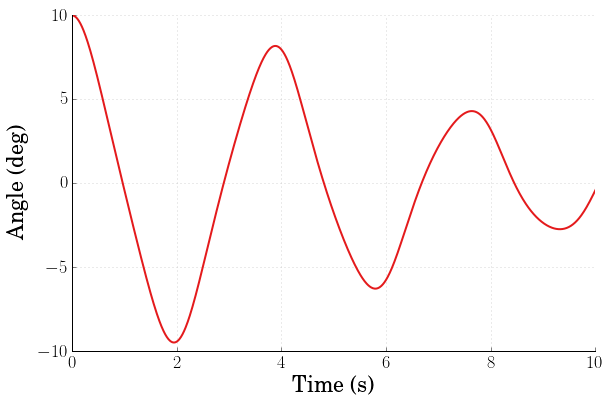

In [18]:
# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(), family='serif', fontsize=18)
plt.setp(ax.get_xmajorticklabels(), family='serif', fontsize=18)

# Remove top and right axes border
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Only show axes ticks on the bottom and left axes
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':', color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Angle (deg)', family='serif', fontsize=22, weight='bold', labelpad=10)

# Plot the data
plt.plot(sim_time, response[:, 1] * 180/np.pi, linewidth=2, linestyle='-', label = '$\theta$')

# uncomment below and set limits if needed
# plt.xlim(0, 5)
# plt.ylim(-1, 1)

# Create the legend, then fix the fontsize
# leg = plt.legend(loc='upper right', ncol = 1, fancybox=True)
# ltext  = leg.get_texts()
# plt.setp(ltext, family='serif', fontsize=20)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# Uncomment to save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
# plt.savefig('Spring_Pendulum_Response_Angle.pdf')

fig.set_size_inches(9, 6) # Resize the figure for better display in the notebook

We can maybe get a better understanding of the response by plotting a planar view of the endpoint motion over time. To do so, we need to define the $x$ and $y$ position of the endpoint.

In [19]:
# Defines the position of the endpoint in x-y
# The origin is set as the pin location
x = response[:,0] * np.sin(response[:,1])
y = -response[:,0] * np.cos(response[:,1])

Now, let's plot the position over time.

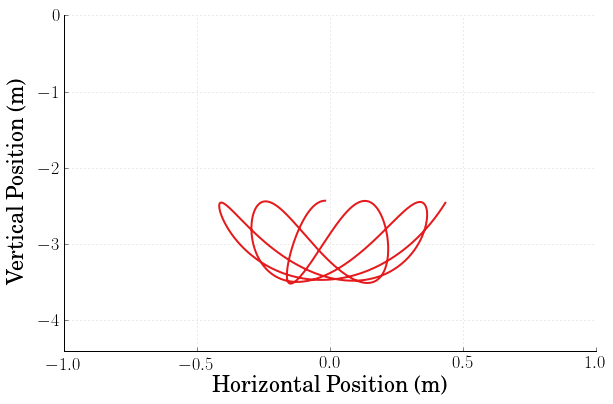

In [20]:
# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(), family='serif', fontsize=18)
plt.setp(ax.get_xmajorticklabels(), family='serif', fontsize=18)

# Remove top and right axes border
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Only show axes ticks on the bottom and left axes
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':', color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Horizontal Position (m)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Vertical Position (m)', family='serif', fontsize=22, weight='bold', labelpad=10)

# Plot the data
plt.plot(x, y, linewidth=2, linestyle='-')

# uncomment below and set limits if needed
plt.xlim(-1, 1)
plt.ylim(1.25*np.min(y), 0.01)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# Uncomment to save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
# plt.savefig('Spring_Pendulum_Response_Planar.pdf')

fig.set_size_inches(9, 6) # Resize the figure for better display in the notebook

<hr class = "style-end">

#### Licenses
Code is licensed under a 3-clause BSD style license. See the licenses/LICENSE.md file.

Other content is provided under a [Creative Commons Attribution-NonCommercial 4.0 International License](http://creativecommons.org/licenses/by-nc/4.0/), CC-BY-NC 4.0.

In [22]:
# Ignore this cell - We just update the CSS to make the notebook look a little bit better and easier to read

# Improve the notebook styling -- Run this first
import codecs
from IPython.core.display import HTML
css_file = 'styling/CRAWLAB_IPythonNotebook.css'
HTML(codecs.open(css_file, 'r', 'utf-8').read())